In [30]:
import os
import re
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [31]:
# Function to count keywords in a text
def count_keywords(text, keywords):
    # Counter object to count occurrences of each keyword
    counts = Counter()
    for keyword in keywords:
        # Count occurrences of the keyword in the text
        counts[keyword] = text.lower().count(keyword)
    return counts

def agg_keywords(df, col_title, keywords):
    # Aggregate 'extracted_sentences' for each 'title' and count keywords
    results = {}
    for title, group in df.groupby('title'):
        # Combine all extracted sentences into one large text block
        aggregated_text = " ".join(group[col_title].tolist())
        # Count the keywords in this aggregated text
        keyword_counts = count_keywords(aggregated_text, keywords)
        # Store the result
        results[title] = keyword_counts

    # Convert the results dictionary to a DataFrame 
    results_df = pd.DataFrame.from_dict(results, orient='index')
    return results_df

In [32]:
# Convert counts to binary values
def convert_to_binary_values(df):
    columns_to_convert = df.columns.tolist()

    # Convert to binary: 1 if the count is greater than 0, else 0
    for column in columns_to_convert:
        df[column] = df[column].apply(lambda x: 1 if x > 0 else 0)
    
    return df

In [33]:
# Reverse the mapping for aggregation
def agg_columns_to_categories(df, keyword_to_category):
    category_to_keywords = {}
    for keyword, category in keyword_to_category.items():
        category_to_keywords.setdefault(category, []).append(keyword)

    # Aggregate columns into categories
    for category, keywords in category_to_keywords.items():
        if category in df.columns:
            # If the category already exists, add to it
            df[category] += df[keywords].sum(axis=1)
        else:
            # Otherwise, create a new column for the category
            df[category] = df[keywords].sum(axis=1)
        # Drop the original keyword columns
        df.drop(columns=keywords, inplace=True)

    return df

In [34]:
# Mapping of keywords to main categories
keyword_to_category = {
    'age'   : 'age_',
    'gender': 'gender_',
    'sex'   : 'gender_',
    'female': 'gender_',
    'women' : 'gender_',
    'woman' : 'gender_',
    'male'  : 'gender_',
    'geolocation'   : 'geolocation_',
    'geographical'  : 'geolocation_',
    'geographic'    : 'geolocation_',
    'country'       : 'geolocation_',
    'countries'     : 'geolocation_',
    'city'          : 'geolocation_',
    'cities'        : 'geolocation_',
    'hospital'      : 'geolocation_',
    'hospitals'     : 'geolocation_',
    'clinic'        : 'geolocation_',
    'clinics'       : 'geolocation_',
    'society'       : 'social factors',
    'societies'     : 'social factors',
    'etnicity'      : 'etnicity_',
    'etnicities'    : 'etnicity_',
    'race'          : 'etnicity_',
    'bias'          : 'bias_',
    'biases'        : 'bias_',
    'unfair'        : 'fairness_',
    'fair'          : 'fairness_',
    'fairness'      : 'fairness_',
    'transparency'  : 'fairness_',
    'awareness'     : 'fairness',
    'imbalance'     : 'fairness_',
    'imbalanced'    : 'fairness_',
    'balance'       : 'fairness_',
    'balanced'      : 'fairness_',
    'problem'       : 'concerns',
    'problems'      : 'concerns',
    'issue'         : 'concerns',
    'issues'        : 'concerns',
    'challenge'     : 'concerns',
    'challenges'    : 'concerns',
    'difficult'     : 'concerns',
    'difficulty'    : 'concerns',
    'difficulties'  : 'concerns'
}

In [62]:
# Mapping of keywords to main categories
keyword_to_category_2 = {
    'age'   : 'age_',
    'gender': 'gender_',
    'sex'   : 'gender_',
    'female': 'gender_',
    'women' : 'gender_',
    'woman' : 'gender_',
    'male'  : 'gender_',
    'patient' : 'patient_',
    'patients': 'patient_',
    'etnicity'      : 'etnicity_',
    'etnicities'    : 'etnicity_',
    'race'          : 'etnicity_',
    'bias'          : 'bias_',
    'biases'        : 'bias_',
    'fairness'      : 'fairness_',
    'imbalance'     : 'fairness_',
    'imbalanced'    : 'fairness_',
    'balance'       : 'fairness_',
    'balanced'      : 'fairness_',
    'transparency'  : 'fairness_',
    'demographics'  : 'demographics_',
    'demographic'   : 'demographics_',
    'data collection': 'data'

   
}

***

In [41]:
# List of keywords
keywords_demographics_long = [
    'age', 'gender', 'sex', 'women', 'woman', 'female', 'male',
    'geolocation', 'geographical', 'geographic', 'country', 'countries', 'city', 'cities', 
    'hospital', 'hospitals', 'clinic', 'clinics', 'society', 'societies',
    'etnicity', 'etnicities', 'race', 
    'bias', 'biases', 'fair', 'unfair', 'fairness', 'transparency', 'awareness',
    'imbalance', 'imbalanced', 'balance', 'balanced',
    'problem', 'problems', 'issue', 'issues', 'challenge', 'challenges', 
    'difficult', 'difficulty', 'difficulties']

# List of keywords
keywords_demographics_short = [
    'age', 'gender', 'sex', 'women', 'woman', 'female', 'male',
    'etnicity', 'etnicities', 'race', 
    'bias', 'biases', 'fair', 'unfair', 'fairness', 'transparency', 
    'imbalance', 'imbalanced', 'balance', 'balanced']

# List of keywords
keywords_demographics_data = [
    'age', 'gender', 'sex', 'women', 'woman', 'female', 'male',
    'patient', 'patients', 'etnicity', 'etnicities', 'race', 
    'bias', 'biases', 'fairness', 'transparency', 
    'imbalance', 'imbalanced', 'balance', 'balanced',
    'demographics', 'demographic', 'data collection']

In [36]:
#filename = '/Users/yasminsarkhosh/Documents/GitHub/machine-learning-bsc-thesis-2024/code/outputs/data/extracted_sentences.csv'
filename = '/Users/yasminsarkhosh/Documents/GitHub/machine-learning-bsc-thesis-2024/code/outputs/data/demographics_data_related_sentences.csv'
extracted_df = pd.read_csv(filename, index_col=0)
print(len(extracted_df['title'].unique())) 

extracted_df

263


,title,extracted_keyword_sent,sub groups
0,Anatomy-Driven Pathology Detection on Chest X-...,"it is\nderived from the mimic-cxr dataset [9,1...","65.079 patients, beth israel deaconess medical..."
1,Self-supervised Learning for Physiologically-B...,the dataset is composed of 23 oncological pati...,"23 patients, oncology, different tumor types"
2,Self-supervised Learning for Physiologically-B...,the dataset included the label maps of 7 organ...,"7 organs, bones, lungs, heart, liver, kidneys,..."
3,Self-supervised Learning for Physiologically-B...,"then, the dataset was split\npatient-wise into...","23 patients, 10 patients for training, 4 patie..."
4,Self-supervised Learning for Physiologically-B...,"in both cases, 75 axial slices per patient wer...","patient, lungs, bladder"
...,...,...,...
1251,InverseSR: 3D Brain MRI Super-Resolution Using...,this network ε θ is conditioned on four condit...,NaN
1252,InverseSR: 3D Brain MRI Super-Resolution Using...,"gender is a binary variable, while the rest of...",NaN
1253,Topology-Preserving Computed Tomography Super-...,λ τ is the\nself-regulating factor.when λ 1 is...,NaN
1254,Topology-Preserving Computed Tomography Super-...,here we used a parameter λ l1 to balance\nthes...,NaN


In [63]:
# Store keyword-match for extracted sentences

# Load the DataFrame from the uploaded file
df = extracted_df

# List of keywords
#keywords = keywords_demographics_long
keywords = keywords_demographics_data

# Initialize columns for each keyword with default value 0
for keyword in keywords:
    df[keyword] = 0

# Function to update the keyword columns based on matches
def update_keyword_columns(row):
    text = row['extracted_keyword_sent']  # Assuming this column holds the extracted sentences
    for keyword in keywords:
        # Update the column for the keyword if it's found in the text
        if keyword in text:
            row[keyword] = 1
    return row

# Apply the function to each row in the DataFrame
df = df.apply(update_keyword_columns, axis=1)
df.head()  # Display the first few rows of the updated DataFrame

# Save the updated DataFrame, if needed
#df.to_csv('/Users/yasminsarkhosh/Documents/GitHub/machine-learning-bsc-thesis-2024/code/outputs/analysis/demo_data__sentences_keyword_counts.csv', index=False)

In [65]:
# Count the number of occurrences of each keyword in the extracted sentences
keyword_counts = agg_keywords(df, 'extracted_keyword_sent', keywords)
keyword_counts
#keyword_counts.to_csv('/Users/yasminsarkhosh/Documents/GitHub/machine-learning-bsc-thesis-2024/code/outputs/analysis/demo_data_total_keyword_counts.csv', index=True)

,age,gender,sex,women,woman,female,male,patient,patients,etnicity,...,biases,fairness,transparency,imbalance,imbalanced,balance,balanced,demographics,demographic,data collection
3D Arterial Segmentation via Single 2D Projections and Depth Supervision in Contrast-Enhanced CT Images,0,0,0,0,0,1,2,2,2,0,...,0,0,0,0,0,0,0,0,0,0
3D Mitochondria Instance Segmentation with Spatio-Temporal Transformers,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A Multi-task Network for Anatomy Identification in Endoscopic Pituitary Surgery,2,0,0,0,0,0,0,2,1,0,...,0,0,0,2,0,2,0,0,0,0
A Novel Video-CTU Registration Method with Structural Point Similarity for FURS Navigation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A Sheaf Theoretic Perspective for Robust Prostate Segmentation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
What Do AEs Learn? Challenging Common Assumptions in Unsupervised Anomaly Detection,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
X2Vision: 3D CT Reconstruction from Biplanar X-Rays with Deep Structure Prior,1,0,0,0,0,0,0,12,7,0,...,0,0,0,0,0,1,0,0,0,0
YONA: You Only Need One Adjacent Reference-Frame for Accurate and Fast Video Polyp Detection,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
atTRACTive: Semi-automatic White Matter Tract Segmentation Using Active Learning,0,0,0,0,0,0,0,2,2,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
# Aggregate the keywords into categories and aggregate the counts by category
refined_keyword_counts_by_categories = agg_columns_to_categories(keyword_counts, keyword_to_category_2)
refined_keyword_counts_by_categories.to_csv('/Users/yasminsarkhosh/Documents/GitHub/machine-learning-bsc-thesis-2024/code/outputs/analysis/refined_demo_data_keyword_counts_by_categories.csv')

In [67]:
# Convert the counts to binary values for each category
binary_keyword_counts_by_categories =  convert_to_binary_values(refined_keyword_counts_by_categories)
binary_keyword_counts_by_categories.to_csv('/Users/yasminsarkhosh/Documents/GitHub/machine-learning-bsc-thesis-2024/code/outputs/analysis/binary_demo_data_keyword_counts_by_categories.csv')

***
## Functions for data visualisations
***

In [68]:
# Plotting the number of category-related keywords in papers 
def plot_category(category, df):
    df[category].value_counts().plot(kind='bar')
    plt.title('Number of Papers Discussing ' + category)
    plt.xlabel('Mentions of ' + category + '-Related Keywords')
    plt.ylabel('Number of Papers')
    plt.show()

In [69]:
# Subplotting the number of category-related keywords in papers
def subplot_categories_binary(categories_to_plot, agg_results_df):
    # Define the number of rows and columns for the subplots based on the number of categories
    num_categories = len(categories_to_plot)
    num_cols = 3  # Choose the number of columns for your subplot grid
    num_rows = num_categories // num_cols + (num_categories % num_cols > 0)

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows))  # Adjust figsize as necessary
    axs = axs.flatten()  # Flatten the array of axes for easier iteration

    total_papers = len(agg_results_df)  # The total number of papers
    
    # Plot a bar plot for each specified category
    for i, category in enumerate(categories_to_plot):
        # Create the bar plot on the appropriate subplot
        # Note: This assumes each entry in these columns is a count. If not, adjust the plotting code accordingly.
        agg_results_df[category].value_counts().sort_index().plot(kind='bar', ax=axs[i], title=category.capitalize(), color='skyblue')
        axs[i].set_xlabel('Mentions of ' + category + '-related keywords')
        axs[i].set_xticks(ticks=[0, 1], labels=['No', 'Yes']) # Customize the x-axis tick labels

        axs[i].set_ylabel('Number of Papers')
        axs[i].set_ylim(0, 300)  # Adjust y-axis limits as necessary
        axs[i].set_title('Number of papers discussing ' + '|' + category + '|', fontsize=10, fontweight='bold', color='white', loc='center', pad=10, weight='bold')
    
        # Add a horizontal line at the total number of papers
        axs[i].axhline(y=total_papers, color='r', linestyle='--', label='papers in total')

        # Add legend to the subplot
        axs[i].legend(loc='lower left', fontsize=8)

    # Hide any unused subplot axes
    for j in range(i + 1, num_rows * num_cols):
        axs[j].set_visible(False)

    # Adjust the layout
    plt.tight_layout()
    plt.show()

In [70]:
def plot_category_percentage_binary(df):    
    # Drop non-category columns
    df_categories = df.drop(df.columns[0], axis=1)

    # Calculate the sum for each category
    category_sums = df_categories.sum()

    # Calculate the percentage for each category
    total_papers = len(df)  # The total number of papers
    category_percentages = (category_sums / total_papers) * 100

    # Create a bar plot with percentage values
    category_percentages.plot(kind='bar', stacked=False, color='skyblue').set_ylim(0, 100) # Set the y-axis limits to 0-100
    plt.title('Category Distribution in Selected Papers', fontsize=12, fontweight='bold', color='white', loc='center', pad=10, weight='bold',
              backgroundcolor='black', ha='center')
    plt.ylabel('Percentage in Total')
    plt.show()

In [71]:
def plot_category_percentage_counts(df):    
    # Drop non-category columns
    xlabels = list(df.columns[1:])
    category_sums = df.sum()[1:]
    total_counts = category_sums.sum()

    category_percentages = []    
    total_word_count = total_counts
    for cat in category_sums:
        percentages = (cat / total_word_count) * 100
        category_percentages.append(percentages)
    
    print(category_percentages)

    # Create a bar plot with percentage values
    plt.bar(xlabels,category_percentages)
    plt.xticks(rotation=90)
    plt.ylim(0, 100) # Set the y-axis limits to 0-100
    plt.title('Keyword counts', fontsize=12, fontweight='bold', color='white', loc='center', pad=10, weight='bold',
              backgroundcolor='black', ha='center')
    plt.ylabel('Percentage in Total')
    plt.show()

In [72]:
binary_keyword_counts_by_categories.columns

Index(['age_', 'gender_', 'patient_', 'etnicity_', 'bias_', 'fairness_',
       'demographics_', 'data'],
      dtype='object')

In [18]:
# Specify the categories you want to plot
categories_to_plot = ['age_', 'gender_', 'geolocation_', 'social factors', 
                      'etnicity_','bias_', 'fairness_', 'fairness', 'concerns']

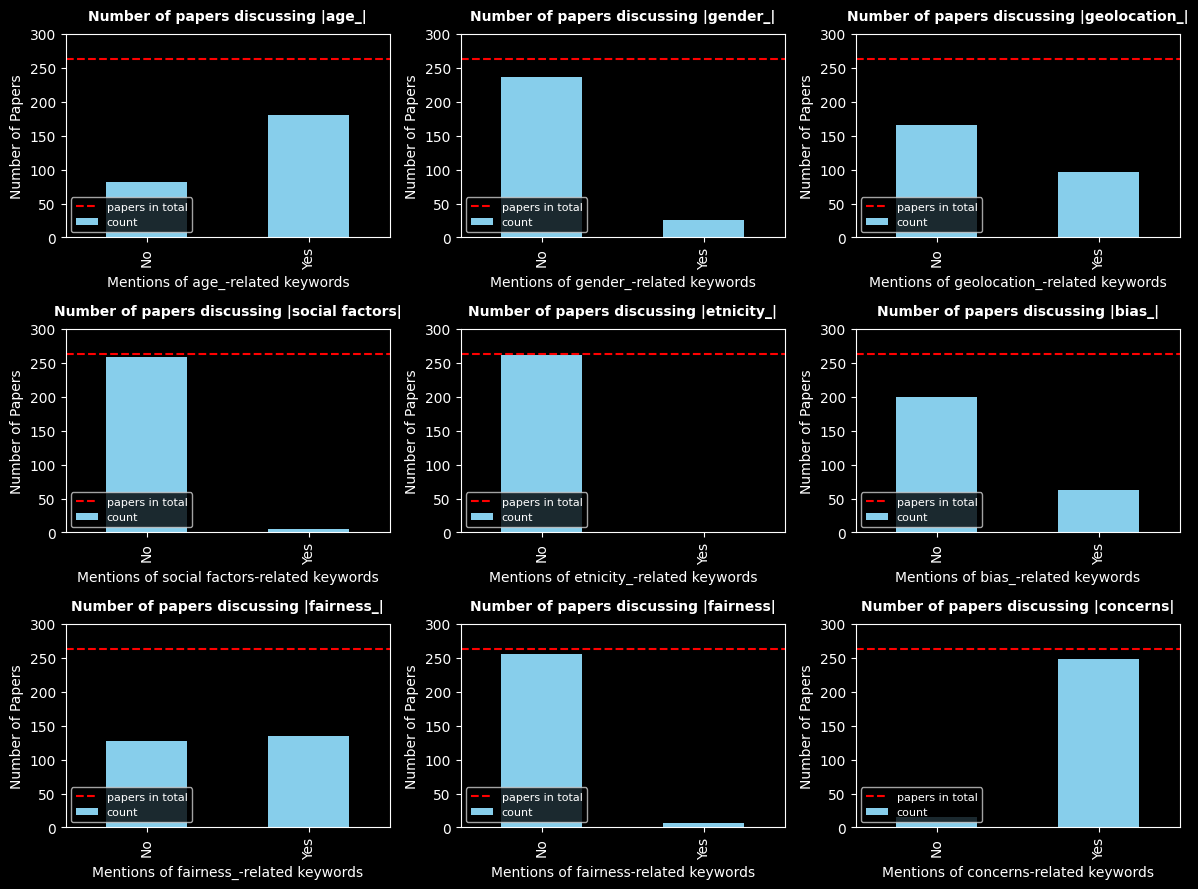

In [25]:
subplot_categories_binary(categories_to_plot, binary_keyword_counts_by_categories)

In [75]:
categories_to_plot_2 = ['age_', 'gender_', 'patient_', 
                      'etnicity_', 'bias_', 'fairness_', 'demographics_', 'data']

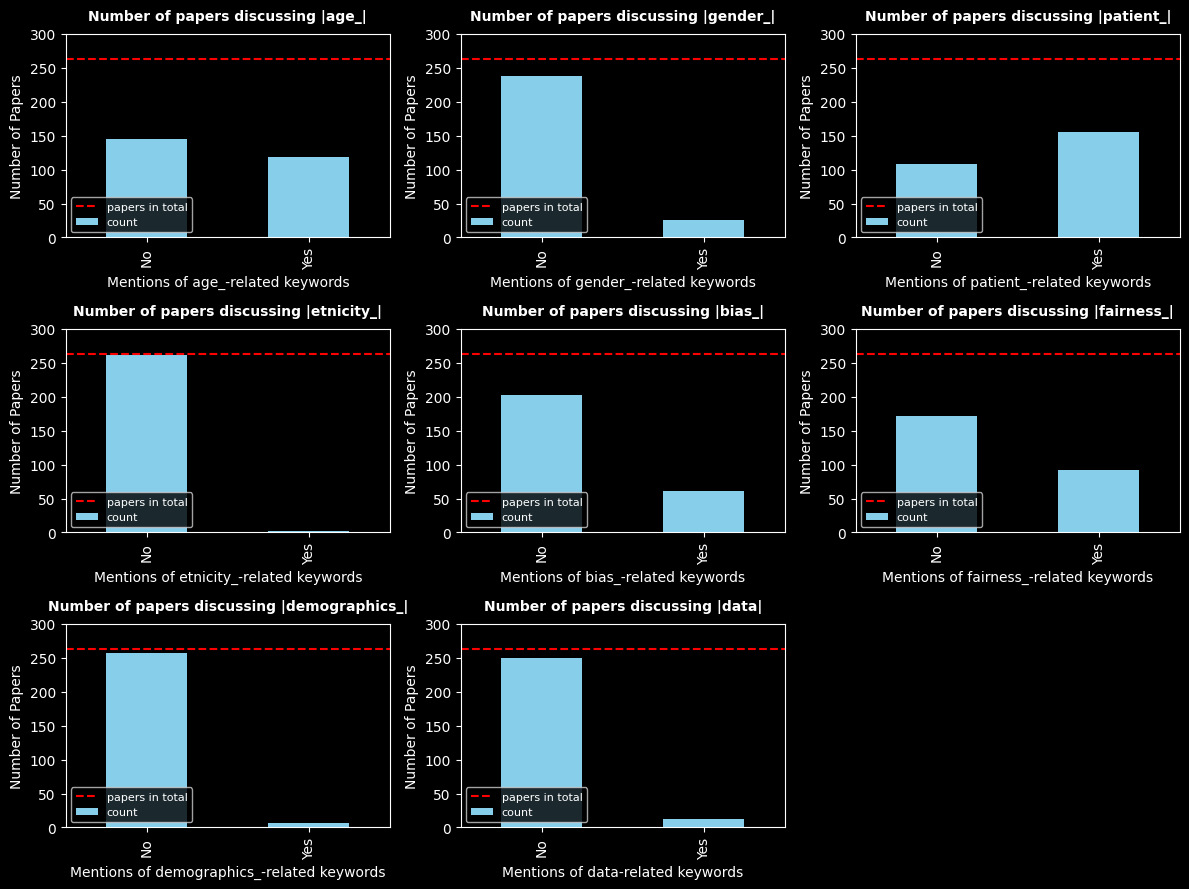

In [76]:
subplot_categories_binary(categories_to_plot_2, binary_keyword_counts_by_categories)

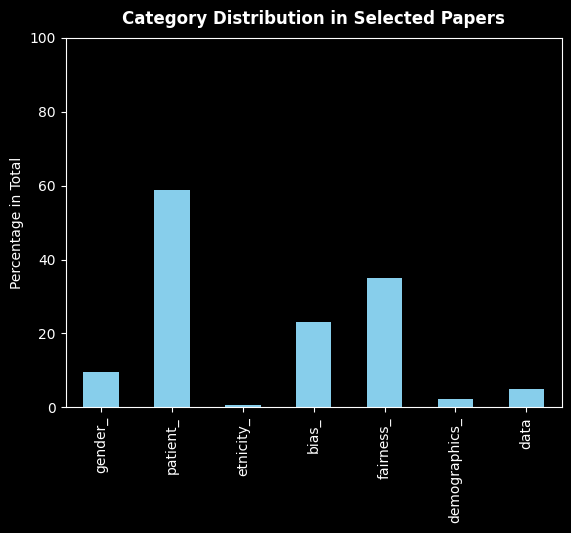

In [77]:
# By binary counts per category
plot_category_percentage_binary(binary_keyword_counts_by_categories)

[7.062146892655368, 43.78531073446328, 0.5649717514124294, 17.231638418079097, 25.98870056497175, 1.694915254237288, 3.672316384180791]


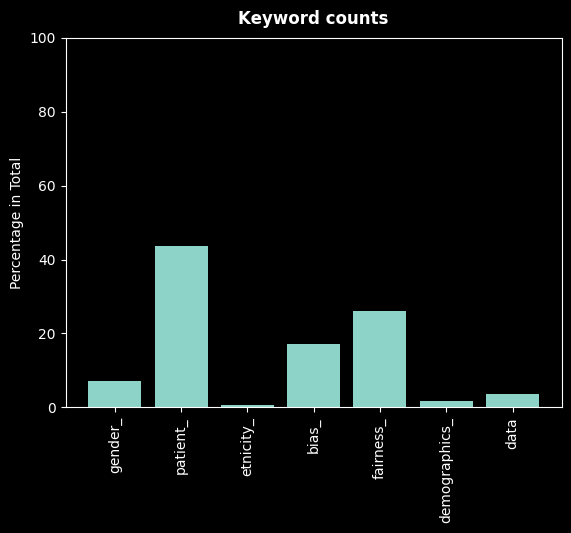

In [78]:
# By total counts per category
plot_category_percentage_counts(refined_keyword_counts_by_categories)